Importing relevant functionalities

In [1]:
import re
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame as df
from sklearn.metrics import r2_score

In [2]:
mols_g16_all = []
for i in range(33):
    i1 = ("%06d" % (i+1))
    i1 = str(i1)
    mols_g16_all.append(i1+'.log')
b3lyp = [] 
blyp = []
cam_b3lyp = []
lc_blyp = []
lc_whpbe = [] 
m062x = [] 
m11 = [] 
pbe1pbe = [] 
pbepbe = [] 
pw91pw91 = [] 
svwn5 = [] 
tpssh = [] 
tpsstpss = []
wb97xd = [] 
wb97xd_svp_at_svp=[]
wb97xd_svpd_at_svp=[]
wb97xd_tzvp_at_tzvp=[]
wb97xd_tzvpd_at_tzvp=[]
functionals_list = [b3lyp, blyp, cam_b3lyp, lc_blyp, lc_whpbe, m062x, m11, pbe1pbe, pbepbe, pw91pw91, svwn5, tpssh,
                   tpsstpss, wb97xd, wb97xd_svp_at_svp, wb97xd_svpd_at_svp, wb97xd_tzvp_at_tzvp, wb97xd_tzvpd_at_tzvp]
f_list = ['b3lyp', 'blyp', 'cam_b3lyp', 'lc_blyp', 'lc_whpbe', 'm062x', 'm11', 'pbe1pbe', 'pbepbe', 'pw91pw91', 
          'svwn5', 'tpssh', 'tpsstpss', 'wb97xd', 'wb97xd_svp_at_svp', 'wb97xd_svpd_at_svp', 
          'wb97xd_tzvp_at_tzvp', 'wb97xd_tzvpd_at_tzvp']
def listtostring(s1):
    str1 = ""
    for ele in s1:
        str1 += ele
    return str1
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
for i in range(len(functionals_list)):
    for j in range(len(mols_g16_all)):
        s = namestr(functionals_list[i], globals())
        t = listtostring(s)
        functionals_list[i].append('../33_benchmark/'+t+'/'+mols_g16_all[j])
steomccsd = []
dlpnosteomccsd = []
composite_list = [steomccsd, dlpnosteomccsd]
mols_orca_all = []
for i in range(33):
    i1 = ("%06d" % (i+1))
    i1 = str(i1)
    mols_orca_all.append(i1+'.out')
for i in range(len(composite_list)):
    for j in range(len(mols_orca_all)):
        s = namestr(composite_list[i], globals())
        t = listtostring(s)
        composite_list[i].append('../33_benchmark/'+t+'/'+mols_orca_all[j])


In [3]:
functionals_list_v = [blyp, pbepbe, pw91pw91, svwn5, tpsstpss]
for i in range(len(functionals_list_v)):
    functionals_list_v[i].pop(11)

Defining required functions

In [4]:
comp_pattern='Normal termination of Gaussian 16'
E1_pattern='Excited State   1:'
E2_pattern='Excited State   2:'
p1 = 4
p2 = 8
def extract_E12_f12_g16(filename):
    file = open(filename, "r")
    iline=0
    for line in file:
        if re.search(comp_pattern, line):
            iline=iline+1
    if (iline < 1):
        print('ERROR: Can\'t find <',comp_pattern,'> in ',filename)
        file.close()
    elif (iline==1):
        file.close()
        file = open(filename, "r")
        mark_e1 = 0
        for l1 in file:
            if re.search(E1_pattern, l1):
                mark_e1 = l1
        file.close()
        file = open(filename, "r")
        mark_e2 = 0
        for l2 in file:
            if re.search(E2_pattern, l2):
                mark_e2 = l2
        file.close()        
    E1 = float( mark_e1.split()[p1] ) 
    f0 = str( mark_e1.split()[p2] ) 
    fx = float(re.sub("[^0123456789\.]", '', f0))
    f1 = float("{:.6f}".format(fx))
    E2 = float( mark_e2.split()[p1] ) 
    f0 = str( mark_e2.split()[p2] ) 
    fx = float(re.sub("[^0123456789\.]", '', f0))
    f2 = float("{:.6f}".format(fx))
    return E1, f1, E2, f2
p1_orca = 2
p2_orca = 3
comp_pattern_orca='ORCA TERMINATED NORMALLY'
Pattern_orca_1='UNRELAXED EXCITED STATE DIPOLE MOMENTS'
Pattern_orca_2='ABSORPTION SPECTRUM VIA TRANSITION ELECTRIC DIPOLE MOMENTS'
def extract_E12_f12_orca(filename):
    file = open(filename, "r")
    iline=0
    for line in file:
        if re.search(comp_pattern_orca, line):
            iline=iline+1
    if (iline < 1):
        print('ERROR: Can\'t find <',comp_pattern_orca,'> in ',filename)
        file.close()
    elif (iline==1):
        file.close()
        file = open(filename, "r")
        line_number = 0
        m1 = 0
        m2 = 0
        for l1 in file:
            line_number += 1
            if re.search(Pattern_orca_1, l1):
                m1 = line_number + 4
                m2 = line_number + 5
        file.close()
        file = open(filename, "r")
        line_number = 0
        mark_e1 = 0
        mark_e2 = 0
        for l1 in file:
            line_number += 1
            if line_number == m1:
                mark_e1 = l1
            if line_number == m2:
                mark_e2 = l1
        file.close()
        
        file = open(filename, "r")
        line_number = 0
        m3 = 0
        m4 = 0
        for l1 in file:
            line_number += 1
            if re.search(Pattern_orca_2, l1):
                m3 = line_number + 5
                m4 = line_number + 6
        file.close()
        file = open(filename, "r")
        line_number = 0
        mark_e3 = 0
        mark_e4 = 0
        for l1 in file:
            line_number += 1
            if line_number == m3:
                mark_e3 = l1
            if line_number == m4:
                mark_e4 = l1
        file.close()       
    E1 = float( mark_e1.split()[p1_orca] ) 
    f1 = float( mark_e3.split()[p2_orca] )
    E2 = float( mark_e2.split()[p1_orca] ) 
    f2 = float( mark_e4.split()[p2_orca] ) 
    return E1, f1, E2, f2

def make_csv(filename,Nrows,Ncols,Header,Values):
    file = open(filename, "w")
    for icol in range(Ncols):
        if icol == Ncols-1:
            file.write(Header[icol]+'\n')
        else:
            file.write(Header[icol]+',')
    for irow in range(Nrows):
        for icol in range(Ncols):
            if icol == Ncols-1:
                file.write(str(Values[icol][irow])+'\n')
            else:
                file.write(str(Values[icol][irow])+',')
    file.close()   
    return 1

Preparing csv files

In [5]:
H1 = ['title', 'E1', 'f1', 'E2', 'f2']
for i in range(len(functionals_list)):
    V = np.zeros([5,len(functionals_list[i])])
    for imol in range(len(functionals_list[i])):
        mol = functionals_list[i][imol]
        E1, f1, E2, f2 =extract_E12_f12_g16(mol)
        V[0,imol] = imol + 1
        V[1,imol] = E1
        V[2,imol] = f1
        V[3,imol] = E2
        V[4,imol] = f2
        s = namestr(functionals_list[i], globals())
        t = listtostring(s)
    tmp = make_csv('../csv_files/'+t+'.csv',len(functionals_list[i]),len(H1),H1,V)
for i in range(len(composite_list)):
    V = np.zeros([5,len(composite_list[i])])
    for imol in range(len(composite_list[i])):
        mol = composite_list[i][imol]
        E1, f1, E2, f2 =extract_E12_f12_orca(mol)
        V[0,imol] = imol + 1
        V[1,imol] = E1
        V[2,imol] = f1
        V[3,imol] = E2
        V[4,imol] = f2
        s = namestr(composite_list[i], globals())
        t = listtostring(s)
    tmp = make_csv('../csv_files/'+t+'.csv',len(composite_list[i]),len(H1),H1,V)
composite_list_v = [steomccsd, dlpnosteomccsd]
for i in range(len(composite_list_v)):
    composite_list_v[i].pop(11)
for i in range(len(composite_list_v)):
    V = np.zeros([5,len(composite_list_v[i])])
    for imol in range(len(composite_list_v[i])):
        mol = composite_list_v[i][imol]
        E1, f1, E2, f2 =extract_E12_f12_orca(mol)
        V[0,imol] = imol + 1
        V[1,imol] = E1
        V[2,imol] = f1
        V[3,imol] = E2
        V[4,imol] = f2
        s = namestr(composite_list_v[i], globals())
        t = listtostring(s)
    tmp = make_csv('../csv_files/'+t+'_v.csv',len(composite_list_v[i]),len(H1),H1,V)

Preparing plots

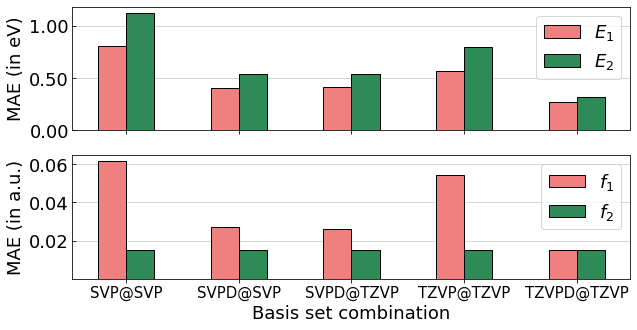

In [18]:
plt.rcParams.update({'font.size': 18})

ref = pd.read_csv('../csv_files/steomccsd.csv',header=0)
ref_v = pd.read_csv('../csv_files/steomccsd_v.csv',header=0)
dlpno = pd.read_csv('../csv_files/dlpnosteomccsd.csv',header=0)
diff_dlpno_E1 = abs(dlpno.E1[:] - ref.E1[:])
diff_dlpno_E2 = abs(dlpno.E2[:] - ref.E2[:])
diff_dlpno_f1 = abs(dlpno.f1[:] - ref.f1[:])
diff_dlpno_f2 = abs(dlpno.f2[:] - ref.f2[:])
mae_E1 = np.zeros(([len(functionals_list)]))
mae_E2 = np.zeros(([len(functionals_list)]))
mae_f1 = np.zeros(([len(functionals_list)]))
mae_f2 = np.zeros(([len(functionals_list)]))
#print(np.mean(diff_dlpno_E1),np.mean(diff_dlpno_E2),np.mean(diff_dlpno_f1),np.mean(diff_dlpno_f2))
for i in range(len(functionals_list)):
    if (len(functionals_list[i])) == 33:
        s = namestr(functionals_list[i], globals())
        t = listtostring(s)
        x = t+'_pd'
        x = pd.read_csv('../csv_files/'+t+'.csv',header=0)
        diff_E1 = abs(x.E1[:] - ref.E1[:])
        diff_E2 = abs(x.E2[:] - ref.E2[:])
        diff_f1 = abs(x.f1[:] - ref.f1[:])
        diff_f2 = abs(x.f2[:] - ref.f2[:])
        
    elif (len(functionals_list[i])) == 32:
        s = namestr(functionals_list[i], globals())
        t = listtostring(s)
        x = t+'_pd'
        x = pd.read_csv('../csv_files/'+t+'.csv',header=0)
        diff_E1 = abs(x.E1[:] - ref_v.E1[:])
        diff_E2 = abs(x.E2[:] - ref_v.E2[:])
        diff_f1 = abs(x.f1[:] - ref_v.f1[:])
        diff_f2 = abs(x.f2[:] - ref_v.f2[:])
        
    #print(f_list[i],np.mean(diff_E1),np.mean(diff_f1),np.mean(diff_E2),np.mean(diff_f2))
    mae_E1[i] = np.mean(diff_E1)
    mae_E2[i] = np.mean(diff_E2)
    mae_f1[i] = np.mean(diff_f1)
    mae_f2[i] = np.mean(diff_f2)
    
fig = plt.figure(figsize = (10, 5))
new_meth = ['svp_at_svp','svpd_at_svp','svpd_at_tzvp','tzvp_at_tzvp','tzvpd_at_tzvp']
mae_E1 = np.zeros(([len(new_meth)]))
mae_E2 = np.zeros(([len(new_meth)]))
mae_f1 = np.zeros(([len(new_meth)]))
mae_f2 = np.zeros(([len(new_meth)]))
for i in range(len(new_meth)):
    x = pd.read_csv('../csv_files/wb97xd_'+new_meth[i]+'.csv',header=0)
    diff_E1 = abs(x.E1[:] - ref.E1[:])
    diff_E2 = abs(x.E2[:] - ref.E2[:])
    diff_f1 = abs(x.f1[:] - ref.f1[:])
    diff_f1 = abs(x.f2[:] - ref.f2[:])
    mae_E1[i] = np.mean(diff_E1)
    mae_E2[i] = np.mean(diff_E2)
    mae_f1[i] = np.mean(diff_f1)
    mae_f2[i] = np.mean(diff_f2)
    #print(new_meth[i],mae_E1[i],mae_f1[i],mae_E2[i],mae_f1[i],)

plt.subplot(2,1,1)
plt.grid(True, linewidth=0.5, linestyle='-', axis = 'y',zorder=0)
barWidth = 0.25
br1 = np.arange(len(new_meth[:]))
br2 = [x + barWidth for x in br1]
new_meth_n = [] 
# Make the plot


plt.bar(br1, mae_E1, color ='lightcoral', width = barWidth,
        edgecolor ='black', label ='$E_1$',zorder=3)
plt.bar(br2, mae_E2, color ='seagreen', width = barWidth,
        edgecolor ='black', label ='$E_2$',zorder=3)
plt.ylabel('MAE (in eV)')
plt.xticks([r + barWidth/2 for r in range(len(new_meth))],new_meth_n)
plt.tick_params(direction="in",which='both',axis='y')
plt.yticks([0.00,0.50,1.00],['0.00','0.50','1.00'])


plt.legend()
new_meth_n = ['SVP@SVP','SVPD@SVP','SVPD@TZVP','TZVP@TZVP','TZVPD@TZVP'] 
plt.subplot(2,1,2)
plt.grid(True, linewidth=0.5, linestyle='-', axis = 'y',zorder=0)
barWidth = 0.25
# Make the plot
plt.bar(br1, mae_f1, color ='lightcoral', width = barWidth,
        edgecolor ='black', label ='$f_1$',zorder=3)
plt.bar(br2, mae_f2, color ='seagreen', width = barWidth,
        edgecolor ='black', label ='$f_2$',zorder=3)

# Adding Xticks
plt.xlabel('Basis set combination')
plt.ylabel('MAE (in a.u.)') #fontweight ='bold'
plt.xticks([r + barWidth/2 for r in range(len(new_meth))],new_meth_n,fontsize=15)
plt.tick_params(direction="in",which='both',axis='y')


plt.yticks([0.02,0.04,0.06],['0.02','0.04','0.06'])


plt.savefig("histogram_basis.pdf",bbox_inches='tight')
 
plt.legend()
plt.show()


In [7]:
# barWidth = 0.20
# br1 = np.arange(len(new_meth[:]))
# br2 = [x + barWidth for x in br1]
# br3 = [x + barWidth for x in br2]
# br4 = [x + barWidth for x in br3]

# Make the plot
# plt.bar(br1, mae_E1, color ='r', width = barWidth,
#         edgecolor ='grey', label ='E1')
# plt.bar(br2, mae_f1, color ='g', width = barWidth,
#         edgecolor ='grey', label ='f1')
# plt.bar(br3, mae_E2, color ='b', width = barWidth,
#         edgecolor ='grey', label ='E2')
# plt.bar(br4, mae_f2, color ='y', width = barWidth,
#         edgecolor ='grey', label ='f2')
 
# # Adding Xticks
# plt.xlabel('Methods', fontweight ='bold', fontsize = 15)
# plt.ylabel('MAE (in eV)', fontweight ='bold', fontsize = 15)
# plt.xticks([r + barWidth for r in range(len(new_meth))],new_meth)
 
# plt.legend()
# plt.show()
# diff_E1=abs(TZVP.E1[:] + SVPD.E1[:] - SVP.E1[:]  - ref.E1[:])
# MAE_E1=np.mean(diff_E1)
# diff_E2=abs(TZVP.E2[:] + SVPD.E2[:] - SVP.E2[:]  - ref.E2[:])
# MAE_E2=np.mean(diff_E2)
# diff_f1=abs(TZVP.f1[:] + SVPD.f1[:] - SVP.f1[:]  - ref.f1[:])
# MAE_f1=np.mean(diff_f1)
# diff_f2=abs(TZVP.f2[:] + SVPD.f2[:] - SVP.f2[:]  - ref.f2[:])
# MAE_f2=np.mean(diff_f2)
# print(MAE_E1, MAE_f1, MAE_E2, MAE_f2)